In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from pathlib import Path

pd.set_option("display.max_rows", 100)
pd.set_option("display.max_columns", 100)

# Data Exploration

In [3]:
# data import

root = Path.cwd().parent
train_path = root / "data" / "interim" / "train_dataset_M1_interim.csv"
df = pd.read_csv(train_path)
df.head()

,id,Age,Gender,Reviews_Read,Price,Discount,Category,Items_In_Cart,Time_of_Day,Email_Interaction,Device_Type,Payment_Method,Referral_Source,Socioeconomic_Status_Score,Engagement_Score,AB_Bucket,Price_Sine,Session_ID,Day,Campaign_Period,Purchase
0,1,NaN,1.0,3.0,592.975,22.0,1.0,6.0,afternoon,0.0,Mobile,Credit,Social_media,7.26,1.856520,3.0,0.999047,S0000003,59,False,0
1,2,25.0,1.0,1.0,511.279,12.0,0.0,3.0,morning,1.0,Tablet,Cash,Social_media,8.30,1.868138,5.0,-0.129689,S0000005,29,True,1
2,3,22.0,0.0,3.0,218.360,2.0,1.0,4.0,evening,1.0,Mobile,Bank,Social_media,6.61,1.223445,0.0,-0.421646,S0000007,16,False,0
3,4,24.0,0.0,3.0,313.781,1.0,3.0,0.0,evening,1.0,Mobile,PayPal,Social_media,10.51,0.359684,1.0,-0.988239,S0000008,53,False,0
4,5,35.0,1.0,1.0,495.088,13.0,0.0,2.0,evening,0.0,Mobile,Cash,Social_media,8.33,3.848580,2.0,0.695737,S0000009,10,False,0


## Drift Report

In [4]:
def calculate_psi(expected, actual, bins=10):
    """
    Calculate Population Stability Index
    
    Parameters:
    expected: distribution in reference period (e.g., pre-campaign)
    actual: distribution in current period (e.g., campaign)
    bins: number of bins to use (default 10 for deciles)
    
    Returns:
    psi: float, PSI value
    """
    
    # Handle edge cases - avoid zeros and infinities
    def safe_divide(numerator, denominator):
        return np.where(denominator != 0, numerator / denominator, 0)
    
    # Create bins based on the combined distribution
    # (use percentiles from both periods combined)
    combined = np.concatenate([expected, actual])
    cut_points = np.percentile(combined, np.linspace(0, 100, bins + 1))
    
    # Avoid duplicate cut points
    cut_points = np.unique(cut_points)
    
    # Bin both distributions
    expected_counts = np.histogram(expected, bins=cut_points)[0]
    actual_counts = np.histogram(actual, bins=cut_points)[0]
    
    # Convert counts to percentages
    expected_pct = safe_divide(expected_counts, expected_counts.sum())
    actual_pct = safe_divide(actual_counts, actual_counts.sum())
    
    # Add small epsilon to avoid log(0)
    epsilon = 1e-10
    expected_pct = np.where(expected_pct == 0, epsilon, expected_pct)
    actual_pct = np.where(actual_pct == 0, epsilon, actual_pct)
    
    # Calculate PSI
    psi = np.sum((actual_pct - expected_pct) * np.log(actual_pct / expected_pct))
    
    return psi

In [5]:
# Population stability index (PSI)
# = sum ( (observed - expectations) * len(obeserved/expectations))

pre_cp_sp = df[df["Day"] < 25]
cp_sp = df[(df["Day"] >= 25) & (df["Day"] < 50)]
post_cp_sp = df[(df["Day"] >= 50) & (df["Day"] < 71)]

# relevant bins to analyze:
# age, Socioeconomic_Status_Score, Engagement_Score

# For all numerical variables
numerical_vars = ["Age", "Socioeconomic_Status_Score", "Engagement_Score"]

psi_results = {}

for var in numerical_vars:
    psi_pre_vs_cp = calculate_psi(
        expected=pre_cp_sp[var].values,
        actual=cp_sp[var].values,
        bins=2
    )
    psi_cp_vs_post = calculate_psi(
        expected=cp_sp[var].values,
        actual=post_cp_sp[var].values,
        bins=2
    )
    psi_pre_vs_post = calculate_psi(
        expected=pre_cp_sp[var].values,
        actual=post_cp_sp[var].values,
        bins=2
    )
    
    psi_results[var] = {
        'pre_vs_campaign': psi_pre_vs_cp,
        'campaign_vs_post': psi_cp_vs_post,
        'pre_vs_post': psi_pre_vs_post
    }

# Create summary table
psi_df = pd.DataFrame(psi_results).T
psi_df['max_drift'] = psi_df.max(axis=1)
psi_df['high_drift'] = psi_df['max_drift'] > 0.2
print(psi_df)


                            pre_vs_campaign  campaign_vs_post  pre_vs_post  \
Age                                     0.0               0.0          0.0   
Socioeconomic_Status_Score              0.0               0.0          0.0   
Engagement_Score                        0.0               0.0          0.0   

                            max_drift  high_drift  
Age                               0.0       False  
Socioeconomic_Status_Score        0.0       False  
Engagement_Score                  0.0       False  


We conclude that the sample are homogeneous in distribution.

χ² and Cramér's V table for categorical features

In [6]:
def calculate_cramers_v(df, col1, col2, verbose=False):
    """
    Calculates the Chi-squared test and Cramer's V.
    Now returns values and only prints if verbose=True.
    """
    contingency_table = pd.crosstab(df[col1], df[col2])
    
    if contingency_table.shape[0] < 2 or contingency_table.shape[1] < 2:
        if verbose: print(f"Skipping '{col1}' vs '{col2}': Not enough unique values.")
        return None, None, None

    try:
        chi2, p_value, dof, expected = stats.chi2_contingency(contingency_table)
    except ValueError as e:
        if verbose: print(f"Skipping '{col1}' vs '{col2}': {e}")
        return None, None, None

    n = contingency_table.sum().sum()
    r, k = contingency_table.shape
    min_dim = min(r - 1, k - 1)
    
    if min_dim == 0:
        cramers_v = 0.0
    else:
        phi_sq = chi2 / n
        cramers_v = np.sqrt(phi_sq / min_dim)

    if verbose:
        print(f"\n--- Analyzing Association: '{col1}' vs '{col2}' ---")
        print(f"Chi-squared Statistic: {chi2:.4f}")
        print(f"P-value: {p_value:.4f}")
        print(f"Cramer's V: {cramers_v:.4f}")
        alpha = 0.05
        if p_value < alpha:
            print(f"Interpretation: IS a statistically significant association.")
        else:
            print(f"Interpretation: is NO statistically significant association.")
            
    return chi2, p_value, cramers_v

def interpret_cramers_v(v):
    """Helper function to add a 'Strength' category."""
    if v < 0.1: return 'Very Weak'
    if v < 0.2: return 'Weak'
    if v < 0.4: return 'Moderate'
    if v < 0.6: return 'Strong'
    return 'Very Strong'

In [7]:
# --- 1. Define your data subsets ---
pre_cp_sp = df[df["Day"] < 25]
cp_sp = df[(df["Day"] >= 25) & (df["Day"] < 50)]
post_cp_sp = df[(df["Day"] >= 50) & (df["Day"] < 71)]

# --- 2. Create the data map for clean naming ---
trunc_data_map = {
    "pre_cp": pre_cp_sp,
    "cp": cp_sp,
    "post_cp": post_cp_sp,
    "all_data": df # Also good to run on the full dataset
}

target_var = 'Purchase'
categorical_vars = [
    'Gender',
    'Device_Type',
    'Time_of_Day',
    'Email_Interaction',
    'Payment_Method',
    'Referral_Source',
    'AB_Bucket',
    'Campaign_Period'
]
# Remove duplicates (Device_Type was listed twice)
categorical_vars = sorted(list(set(categorical_vars))) 

results = {}

# --- 3. Run the corrected loop ---
# We loop over the map's .items() to get both the name and the data
for data_name, data_subset in trunc_data_map.items():
    if data_subset.empty:
        print(f"Skipping '{data_name}': No data in this period.")
        continue
    
    for var in categorical_vars:
        if var in data_subset.columns:
            # *** THE FIXES ***
            # 1. Pass the correct data_subset (not the whole 'df')
            # 2. Set verbose=False to keep the loop quiet
            chi2, p, v = calculate_cramers_v(data_subset, var, target_var, verbose=False)
            
            if v is not None:
                # 3. Use the clean 'data_name' for the index
                key = f'{var}_{data_name}'
                results[key] = {'chi2': chi2, 'p_value': p, 'cramers_v': v}
        else:
            print(f"\n--- Skipping '{var}': Not found in DataFrame. ---")

# --- 4. Create the final "Synthetic" summary ---
print("\n" + "="*50)
print(f"Synthetic Summary of Associations with '{target_var}'")
print("="*50)

if results:
    results_df = pd.DataFrame(results).T

    # Add the interpretation columns
    results_df['Significance'] = np.where(
        results_df['p_value'] < 0.05, 
        'Significant (p<0.05)', 
        'Not Significant'
    )

    results_df['Strength'] = results_df['cramers_v'].apply(interpret_cramers_v)

    # Sort by importance (cramers_v)
    results_df = results_df.sort_values(by='cramers_v', ascending=False)

    # Reorder columns for clarity
    print(results_df[[
        'cramers_v', 
        'p_value', 
        'Significance', 
        'Strength',
        'chi2'
        ]])
else:
    print("No valid results to summarize.")


Synthetic Summary of Associations with 'Purchase'
                            cramers_v       p_value          Significance  \
Email_Interaction_pre_cp     0.123432  2.750829e-17  Significant (p<0.05)   
Email_Interaction_all_data   0.117110  4.447578e-42  Significant (p<0.05)   
Email_Interaction_cp         0.113765  4.251015e-15  Significant (p<0.05)   
Email_Interaction_post_cp    0.112755  8.794648e-13  Significant (p<0.05)   
Device_Type_post_cp          0.111242  1.795381e-11  Significant (p<0.05)   
Device_Type_pre_cp           0.106135  3.352486e-12  Significant (p<0.05)   
Campaign_Period_all_data     0.104039  3.386939e-34  Significant (p<0.05)   
Device_Type_all_data         0.099052  2.138687e-29  Significant (p<0.05)   
Device_Type_cp               0.083895  5.178775e-08  Significant (p<0.05)   
Referral_Source_cp           0.059416  1.836438e-03  Significant (p<0.05)   
AB_Bucket_post_cp            0.039616  3.933091e-01       Not Significant   
Referral_Source_post_cp  

Email_interaction and Device_Type have significant link (chi²) with weak strenght (cramer).

➡️ Efforts in email have an impact on sales.

➡️ The device seems to matter in the buying decision, need further checking.

Additionnally, the Referral Source is significant but with very weak strenght:

➡️ This strongly implies the campaign successfully made Referral_Source an important factor (ads on social media, so "Social_media" became a significant source). This effect wore off as soon as the campaign ended.



## Segment summary

In [8]:
def get_confidence_interval(p, n, z=1.96):
    """
    Calculates the 95% confidence interval for a proportion (purchase rate).
    
    Args:
        p (float): The purchase rate (proportion).
        n (int): The number of sessions (sample size).
        z (float): The z-score for 95% confidence.

    Returns:
        tuple: (lower_bound, upper_bound)
    """
    if n == 0:
        return 0.0, 0.0 # No sessions, no interval
    
    # Wilson score interval is more stable for small n or p near 0/1
    # but for simplicity and large numbers, Wald interval is fine.
    # Let's use the standard Wald interval as requested: p +/- z * sqrt(p(1-p)/n)
    
    # Handle edge case where p=0 or p=1 to avoid 0 in sqrt
    if p * (1 - p) < 0: 
        p = np.clip(p, 0.00001, 0.99999)

    margin_of_error = z * np.sqrt((p * (1 - p)) / n)
    
    lower_bound = max(0.0, p - margin_of_error)
    upper_bound = min(1.0, p + margin_of_error)
    
    return lower_bound, upper_bound

In [9]:
# --- Step 1: Calculate Global Baseline Rate ---
global_sessions = len(df)
global_conversions = df['Purchase'].sum()
global_purchase_rate = global_conversions / global_sessions

print(f"Global Baseline Rate: {global_purchase_rate:.4f} ({global_conversions}/{global_sessions} sessions)")
print("-" * 60)

# --- Step 2: Define features to analyze ---
features = [
    "Device_Type",
    "Time_of_Day",
    "Category",
    "Email_Interaction",
    "Campaign_Period"
]

all_segments = []

# --- Step 3: Loop and use groupby() for efficient calculation ---
for feature in features:
    print(f"Processing feature: {feature}...")
    
    # Group by the feature and aggregate
    segment_group = df.groupby(feature).agg(
        Sessions=('Purchase', 'count'),      # Total rows in segment
        Conversions=('Purchase', 'sum')      # Total 1s in segment
    )
    
    # Calculate rates for each segment in the group
    segment_group['Purchase_Rate'] = segment_group['Conversions'] / segment_group['Sessions']
    
    # Calculate Lift
    segment_group['Lift'] = segment_group['Purchase_Rate'] / global_purchase_rate
    
    # Calculate 95% CI
    # We use .apply() to run our function on each row of the grouped DataFrame
    segment_group['95%_CI'] = segment_group.apply(
        lambda row: get_confidence_interval(row['Purchase_Rate'], row['Sessions']),
        axis=1
    )
    
    # Add feature name and reset index to make it a clean table
    segment_group['Feature'] = feature
    segment_group = segment_group.reset_index().rename(columns={feature: 'Segment'})
    
    all_segments.append(segment_group)

# --- Step 4: Combine all results into one final DataFrame ---
segment_map_df = pd.concat(all_segments, ignore_index=True)

# --- Step 5: Format and Sort ---
# Unpack the CI tuple into two separate columns for better sorting
segment_map_df[['95%_CI_Low', '95%_CI_High']] = pd.DataFrame(
    segment_map_df['95%_CI'].tolist(), 
    index=segment_map_df.index
)

# Reorder and select final columns
final_columns = [
    'Feature', 'Segment', 'Sessions', 'Conversions', 
    'Purchase_Rate', 'Lift', '95%_CI_Low', '95%_CI_High'
]
segment_map_df = segment_map_df[final_columns]

# Sort by Lift (highest first) to see top-performing segments
segment_map_df = segment_map_df.sort_values(by='Lift', ascending=False)

# Format for nice printing
pd.set_option('display.max_rows', 50)
segment_map_df['Purchase_Rate'] = segment_map_df['Purchase_Rate'].map('{:.2%}'.format)
segment_map_df['Lift'] = segment_map_df['Lift'].map('{:.2f}x'.format)
segment_map_df['95%_CI_Low'] = segment_map_df['95%_CI_Low'].map('{:.2%}'.format)
segment_map_df['95%_CI_High'] = segment_map_df['95%_CI_High'].map('{:.2%}'.format)


print("\n" + "="*60)
print("FINAL SEGMENT MAP (Sorted by Lift)")
print("="*60)
print(segment_map_df.to_string()) # .to_string() ensures all rows print

Global Baseline Rate: 0.3681 (5056/13735 sessions)
------------------------------------------------------------
Processing feature: Device_Type...
Processing feature: Time_of_Day...
Processing feature: Category...
Processing feature: Email_Interaction...
Processing feature: Campaign_Period...

FINAL SEGMENT MAP (Sorted by Lift)
              Feature    Segment  Sessions  Conversions Purchase_Rate   Lift 95%_CI_Low 95%_CI_High
14    Campaign_Period       True      5048         2191        43.40%  1.18x     42.04%      44.77%
2         Device_Type     Tablet      2005          865        43.14%  1.17x     40.97%      45.31%
12  Email_Interaction        1.0      6134         2629        42.86%  1.16x     41.62%      44.10%
6            Category        0.0      2690         1146        42.60%  1.16x     40.73%      44.47%
8            Category        2.0      2597         1080        41.59%  1.13x     39.69%      43.48%
7            Category        1.0      2778         1122        40.39% 

In [10]:
seg_path = root / "data" / "interim" / "segment_summary.csv"
segment_map_df.to_csv(seg_path)

In [11]:
# Example of an overlapping high_lift segment

# Create high-lift segment flags
df['is_high_value'] = (
    ((df['Category'].isin([0.0, 1.0, 2.0])) & (df['Device_Type'].isin(['Tablet', 'Desktop'])) & (df['Email_Interaction'] == 1.0))
)

# Count overlapping high-lift segments
high_value_customers = df[df['is_high_value']]
print(f"High-value customer sessions: {len(high_value_customers)}")
print(f"Expected conversions: {high_value_customers['Purchase'].sum()}")
print(f"Projected conversion rate: {high_value_customers['Purchase'].mean():.2%}")

# Calculate budget efficiency
budget_cap = 2000  # Daily contact limit
roi = high_value_customers['Purchase'].sum() / budget_cap
print(f"Expected ROI per contact: {roi:.2f} conversions/contact")


High-value customer sessions: 1944
Expected conversions: 1010
Projected conversion rate: 51.95%
Expected ROI per contact: 0.51 conversions/contact


From the segment analysis there are mutliple things we can takeaway:

- Device_Type (Tablet, Desktop); Email_Interaction(1.0); Category (0.0, 1.0, 2.0) are the most relevant segments in terms of lift.

The list represents measures the incremental impact of a campaing compared to what would have happened naturally.

Some playbook rules might include:

- Focus a significant part of the ads budget on high lift x session volume segments (using ML to find complex overlapping segments).

- Reduce/cut the ads budget on low lift x session volume segments (using ML to find complex overlapping segments).

## Daily volume

In [12]:
def period_label(day):
    if day < 25:
        return "Pre"
    elif 25 <= day <= 50:
        return "Campaign"
    else:
        return "Post"

In [13]:
# distribution of the sales (for a volume of buyer) & marketing budget + average basket 
daily_sales = df[df["Purchase"]==1].groupby("Day").agg(
    Avg_Price=('Price', 'mean'),
    Avg_Items_In_Cart=('Items_In_Cart', 'mean'),
    Turnover=('Price', 'sum'),
    Volume=('Items_In_Cart', 'sum'),
    Avg_Age=('Age', 'mean'),
    Gender_Concentration=('Gender', 'mean'),
    Avg_Socioeconomic_Status=('Socioeconomic_Status_Score','mean'),
    Avg_Engagement_Score=('Engagement_Score', 'mean')
)

daily_sales_long = daily_sales.reset_index().melt(
    id_vars='Day', 
    var_name='Metric',  # Column for the metric names (e.g., 'Avg_Price')
    value_name='Value'  # Column for the metric values
)
daily_sales_long["Period"] = daily_sales_long["Day"].apply(period_label)
period_means = (
    daily_sales_long.groupby(["Metric", "Period"])["Value"]
    .mean()
    .reset_index()
)

daily_sales_long.head()

,Day,Metric,Value,Period
0,1,Avg_Price,417.990797,Pre
1,2,Avg_Price,418.351594,Pre
2,3,Avg_Price,439.219435,Pre
3,4,Avg_Price,440.768293,Pre
4,5,Avg_Price,402.230507,Pre


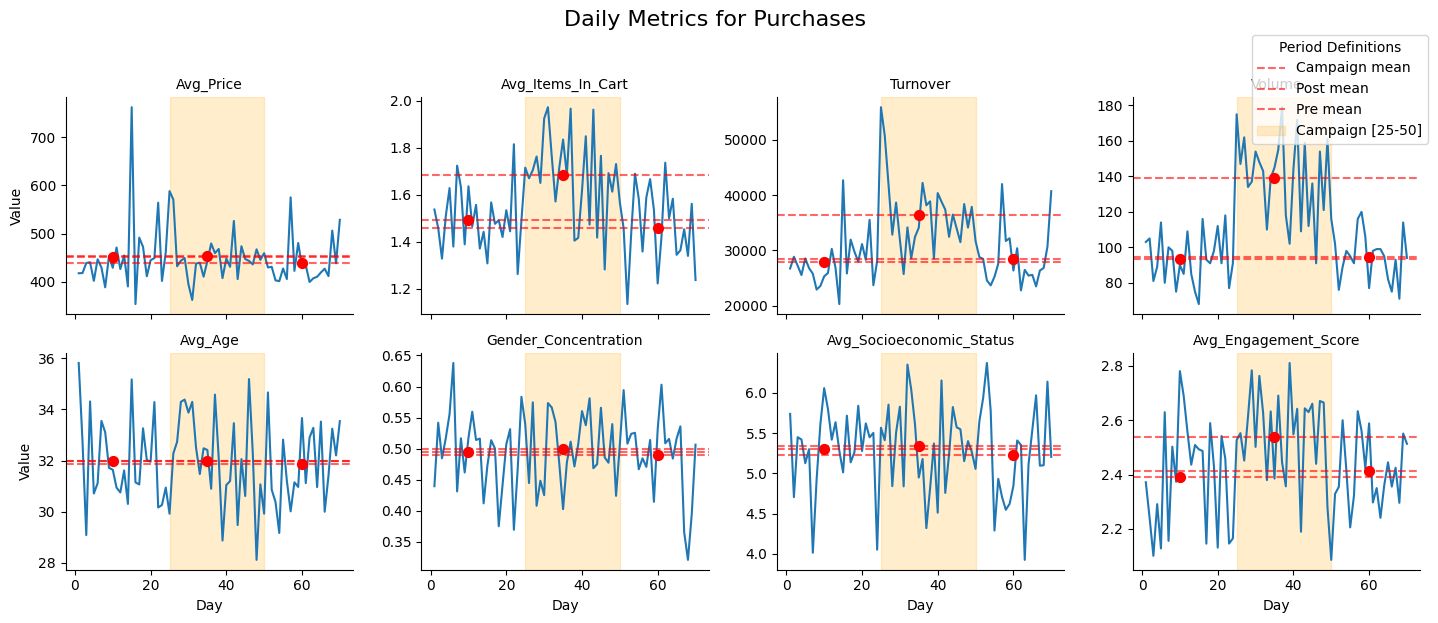

In [ ]:
g = sns.relplot(
    data=daily_sales_long,
    x='Day',
    y='Value',
    col='Metric',
    kind='line',
    col_wrap=4,
    height=3,
    aspect=1.2,
    
    facet_kws={'sharey': False, 'sharex': True},
    legend=False  # Crucially set to False to handle manually later
)

# Initialize a list to store legend handles and labels from the first subplot
handles = []
labels = []
first_ax = g.axes.flat[0] # Use the first subplot to collect handles

# Overlay mean lines/points
for ax, metric in zip(g.axes.flat, g.col_names):
    # Subset means for this metric
    subset = period_means[period_means["Metric"] == metric]
    
    # 1. Plot Mean Lines and Points
    for _, row in subset.iterrows():
        period_label = f"{row['Period']} mean"
        
        # Check if we should collect the handle/label (only do it once)
        collect_handle = period_label not in labels

        # Horizontal line for mean
        line = ax.axhline(
            y=row["Value"],
            linestyle="--",
            color="red",
            alpha=0.6,
            label=period_label if collect_handle else None # Only label for collection
        )
        
        # Optional scatter marker
        ax.scatter(
            x=[35 if row["Period"]=="Campaign" else (10 if row["Period"]=="Pre" else 60)],
            y=[row["Value"]],
            color="red",
            marker="o",
            zorder=5,
            s=50
        )
        
        if collect_handle:
            # For the line handles, we just need the line object
            if line not in handles:
                handles.append(line)
                labels.append(period_label)

# 2. Add Campaign Shading (axvspan)
# This loop runs for every axis, so we must be careful with the label
for i, ax in enumerate(g.axes.flat):
    campaign_label = 'Campaign [25-50]'
    
    # Check if we should collect the handle/label (only do it once on the first axis)
    collect_handle = (i == 0)

    patch = ax.axvspan(
        25, 50, 
        alpha=0.2, 
        color='orange',
        label=campaign_label if collect_handle else None, 
        zorder=1
    )
    
    if collect_handle:
        # For the axvspan, the handle is the rectangle object itself
        handles.append(patch)
        labels.append(campaign_label)

# 3. Create the Unified Legend on the Figure
# Place the legend outside the plot area
g.fig.legend(
    handles, 
    labels, 
    title='Period Definitions',
    loc='upper right', 
    bbox_to_anchor=(1.0, 1.0)
)


# Set titles and layout
g.fig.suptitle('Daily Metrics for Purchases', y=1.03, fontsize=16)
g.set_titles("{col_name}") # Use the metric name as the subplot title
plt.tight_layout()
plt.show()


Part 1: Historical Analysis (All 71 Days)
Total days analyzed: 70
Days with sessions > 2000: 0 (0.0%)


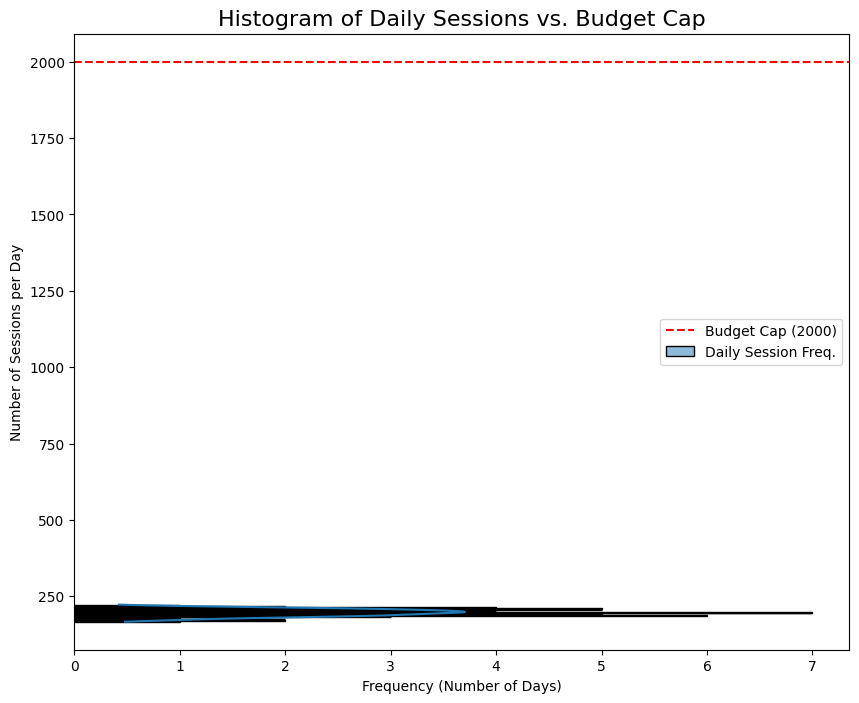


Part 2: Budget Cap Simulation (Days 1+)
Daily Simulation Results:
    Day  Total_Sessions  Cap_Binds?  Total_Purchases_Possible  Purchases_Captured_by_Cap  Purchases_Missed
0     1             210       False                        68                         68                 0
1     2             188       False                        74                         74                 0
2     3             195       False                        65                         65                 0
3     4             206       False                        61                         61                 0
4     5             198       False                        72                         72                 0
5     6             205       False                        60                         60                 0
6     7             195       False                        60                         60                 0
7     8             181       False                        61                

In [15]:
# --- Constants ---
BUDGET_CAP = 2000
VALIDATION_START_DAY = 1 # Assuming days 1-70 are for validation

# =========================================================================
# Part 1: Historical Analysis (Sessions/Day Histogram)
# =========================================================================
print("\n" + "="*60)
print(f"Part 1: Historical Analysis (All {df['Day'].max() + 1} Days)")
print("="*60)

# Compute sessions per day
daily_sessions = df.groupby('Day').size().reset_index(name='Sessions')

# Count days with > 2,000 sessions
days_over_cap = daily_sessions[daily_sessions['Sessions'] > BUDGET_CAP]

print(f"Total days analyzed: {len(daily_sessions)}")
print(f"Days with sessions > {BUDGET_CAP}: {len(days_over_cap)} ({len(days_over_cap) / len(daily_sessions):.1%})")

# Plot the histogram (horizontal)
plt.figure(figsize=(10, 8)) # Adjusted figsize for vertical plot
sns.histplot(y=daily_sessions['Sessions'], bins=30, kde=True, label='Daily Session Freq.')

# Add the budget cap line (horizontal)
plt.axhline(BUDGET_CAP, color='red', linestyle='--', 
            label=f'Budget Cap ({BUDGET_CAP})')
            
plt.title('Histogram of Daily Sessions vs. Budget Cap', fontsize=16)
plt.ylabel('Number of Sessions per Day') # Swapped
plt.xlabel('Frequency (Number of Days)') # Swapped
plt.legend()
plt.show()

# =========================================================================
# Part 2: Simulation on Validation Days
# =========================================================================
print("\n" + "="*60)
print(f"Part 2: Budget Cap Simulation (Days {VALIDATION_START_DAY}+)")
print("="*60)

# Isolate validation data
validation_df = df[df['Day'] >= VALIDATION_START_DAY].copy()

if validation_df.empty:
    print("No validation data found to run simulation.")
else:
    # Add a placeholder score (a random number)
    # This simulates our "ranking"
    validation_df['placeholder_score'] = np.random.rand(len(validation_df))

    validation_days = sorted(validation_df['Day'].unique())
    simulation_results = []

    for day in validation_days:
        # Get all data for that specific day
        day_data = validation_df[validation_df['Day'] == day]
        
        total_sessions = len(day_data)
        total_purchases_possible = day_data['Purchase'].sum()
        
        # Check if the cap binds (is the limit reached?)
        cap_binds = total_sessions > BUDGET_CAP
        
        # Simulate picking the "top-K" by sorting by our score
        # and taking the top 2000 (or all, if fewer than 2000)
        budgeted_sessions = day_data.sort_values(
            by='placeholder_score', ascending=False
        ).head(BUDGET_CAP)
        
        # Calculate purchases captured by our budgeted group
        purchases_captured = budgeted_sessions['Purchase'].sum()
        
        # Calculate what we missed due to the cap
        purchases_missed = total_purchases_possible - purchases_captured
        
        simulation_results.append({
            "Day": day,
            "Total_Sessions": total_sessions,
            "Cap_Binds?": cap_binds,
            "Total_Purchases_Possible": total_purchases_possible,
            "Purchases_Captured_by_Cap": purchases_captured,
            "Purchases_Missed": purchases_missed
        })

    # --- Print Simulation Summary ---
    results_df = pd.DataFrame(simulation_results)
    print("Daily Simulation Results:")
    print(results_df.to_string())
    
    # --- Print Synthetic Summary ---
    total_binding_days = results_df['Cap_Binds?'].sum()
    total_missed_purchases = results_df['Purchases_Missed'].sum()
    total_captured_purchases = results_df['Purchases_Captured_by_Cap'].sum()
    total_possible = results_df['Total_Purchases_Possible'].sum()
    
    print("\n--- Simulation Summary ---")
    print(f"Validation Days Analyzed: {len(results_df)}")
    print(f"Budget Cap Bound (was hit) on: {total_binding_days} days ({total_binding_days / len(results_df):.1%})")
    print(f"Total Purchases Captured (Budget): {total_captured_purchases}")
    print(f"Total Purchases Missed due to Cap: {total_missed_purchases}")
    print(f"Total Possible Purchases (No Cap): {total_possible}")
    
    if total_possible > 0:
        capture_rate = total_captured_purchases / total_possible
        print(f"  -> Your {BUDGET_CAP}-session cap captured {capture_rate:.1%} of potential purchases.")

We can conclude from the analysis that Gender, Age, Socioeconomic_Status are similar whether we are during a campaign or not.
Additionnally, we notice a strong mean-reversing tendency for variables with strong difference between post-campaign period and campaign period.

We should be able to get most the relevant sessions since the converted sessions do not exceed around 250 per day (12.5% of our target budget must convert)

## Campaign effect

Here are general statistics about the effect of campaigns. Further details can also be viewed in the section Daily Volume.

In [16]:
# purchase rate of vistors for days 1-70 with condifence intervals and shaded region for campaign regions

daily_stat = df.groupby("Day").agg(
    Total_sessions=('Session_ID', 'count'),
    Purchases=('Purchase', 'sum')
)

daily_stat["Purchase Rate"] = daily_stat["Purchases"] / daily_stat["Total_sessions"] * 100
daily_stat = daily_stat.reset_index()
daily_stat["Moving_average_7D"]=daily_stat["Purchase Rate"].rolling(window=7, center=False).mean()
daily_stat.head(10)

,Day,Total_sessions,Purchases,Purchase Rate,Moving_average_7D
0,1,203,68,33.497537,NaN
1,2,183,74,40.437158,NaN
2,3,193,65,33.678756,NaN
3,4,202,61,30.198020,NaN
4,5,190,72,37.894737,NaN
5,6,200,60,30.000000,NaN
6,7,189,60,31.746032,33.921749
7,8,177,61,34.463277,34.059711
8,9,193,56,29.015544,32.428052
9,10,200,60,30.000000,31.902516


In [17]:
# Print summary stats
print(f"Overall avg purchase rate: {daily_stat['Purchase Rate'].mean():.2f}%")
print(f"Campaign period avg: {daily_stat.iloc[24:51]['Purchase Rate'].mean():.2f}%")
print(f"Non-campaign period avg: {daily_stat[~daily_stat['Day'].isin(list(range(25,51))+list(range(75,91)))]['Purchase Rate'].mean():.2f}%")

Overall avg purchase rate: 37.69%
Campaign period avg: 44.18%
Non-campaign period avg: 33.72%


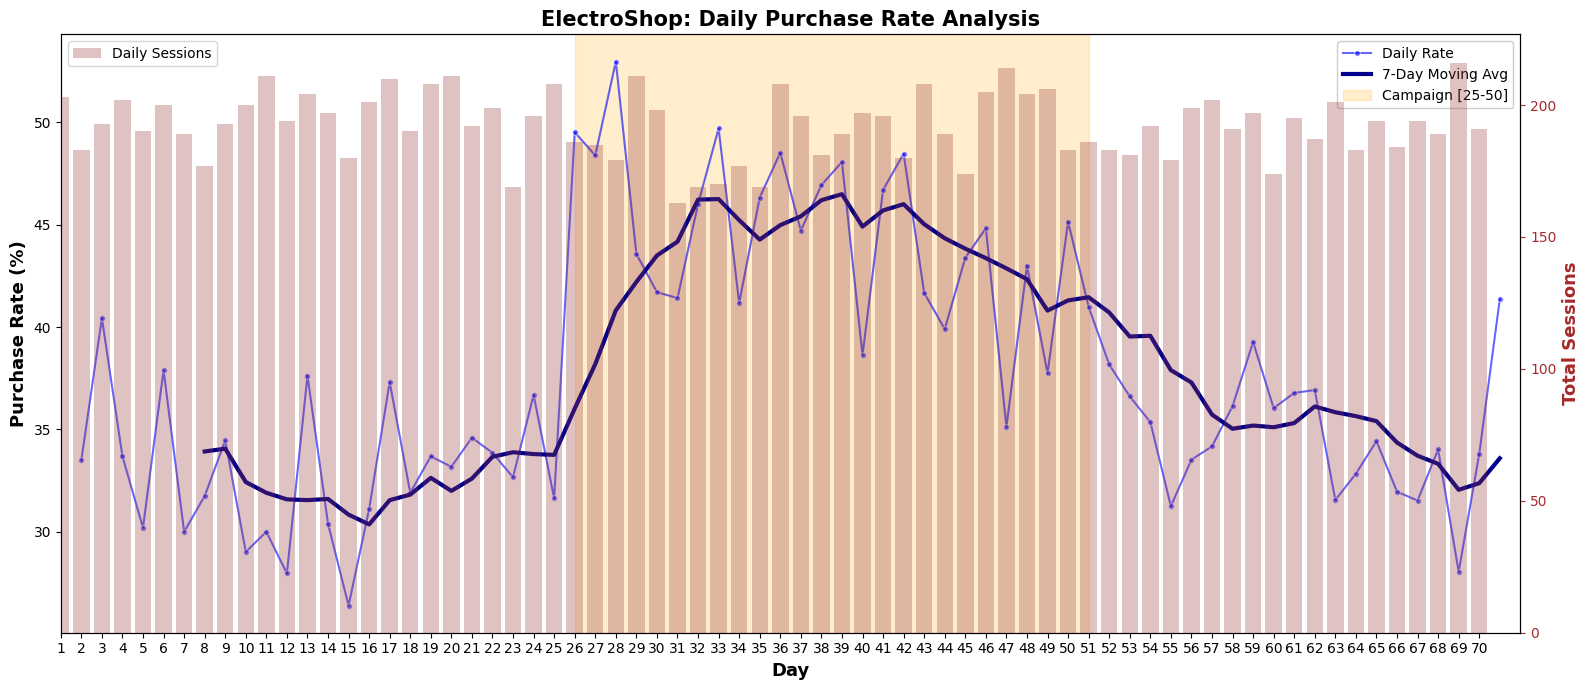

In [18]:
# Create figure
fig, ax = plt.subplots(figsize=(16, 7))

# Plot raw daily rate with seaborn
sns.lineplot(data=daily_stat,
             x='Day',
             y='Purchase Rate',
             marker='o',
             markersize=4,
             linewidth=1.5,
             alpha=0.6,
             color='blue',
             label='Daily Rate',
             ax=ax)

# Plot moving average (still using seaborn's styling)
sns.lineplot(data=daily_stat,
             x='Day',
             y='Moving_average_7D',
             marker=None,
             linewidth=3,
             color='darkblue',
             label='7-Day Moving Avg',
             ax=ax)

ax2 = ax.twinx()

# --- Plot Total Sessions on the secondary axis (ax2) ---
sns.barplot(data=daily_stat,
            x='Day',
            y='Total_sessions',
            alpha=0.3,
            color='brown',
            label='Daily Sessions',
            ax=ax2) 

# Labels and formatting for secondary axis
ax2.set_ylabel('Total Sessions', fontsize=13, fontweight='bold', color='brown')
ax2.tick_params(axis='y', colors='brown')
ax2.grid(False) # Turn off grid for the secondary axis
ax2.set_zorder(1) # Send bar plot "to the back"

# Campaign shading
ax.axvspan(25, 50, alpha=0.2, color='orange', label='Campaign [25-50]', zorder=0)

# Labels and formatting
ax.set_xlabel('Day', fontsize=13, fontweight='bold')
ax.set_ylabel('Purchase Rate (%)', fontsize=13, fontweight='bold')
ax.set_title('ElectroShop: Daily Purchase Rate Analysis', fontsize=15, fontweight='bold')
ax.legend(loc='best', framealpha=0.95)
ax.set_xlim(0, 71)

plt.tight_layout()
plt.show()


# Naive Bayes

In [19]:
cols_to_drop = ['id', 'Session_ID', 'Time_of_Day', 'Device_Type', 'Payment_method', 'Referral_Source', 'Campaign_Period','Category']

df_for_cov = df.drop(columns=[c for c in cols_to_drop if c in df.columns]) \
               .select_dtypes(include=[np.number])

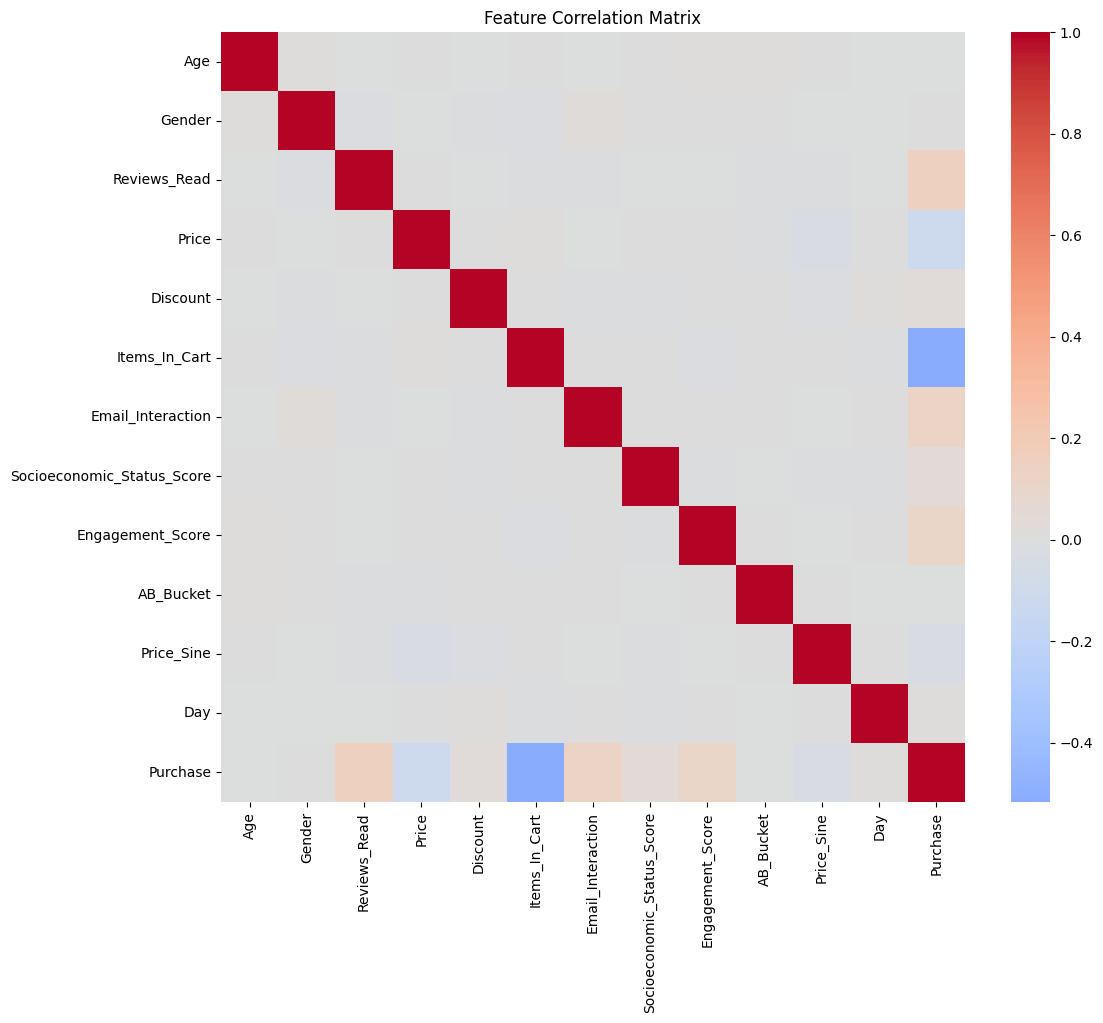

In [20]:
# Calculate correlation matrix for numerical columns
corr = df_for_cov.corr(numeric_only=True)

# Plot
plt.figure(figsize=(12, 10))
sns.heatmap(corr, annot=False, cmap='coolwarm', center=0)
plt.title("Feature Correlation Matrix")
plt.show()

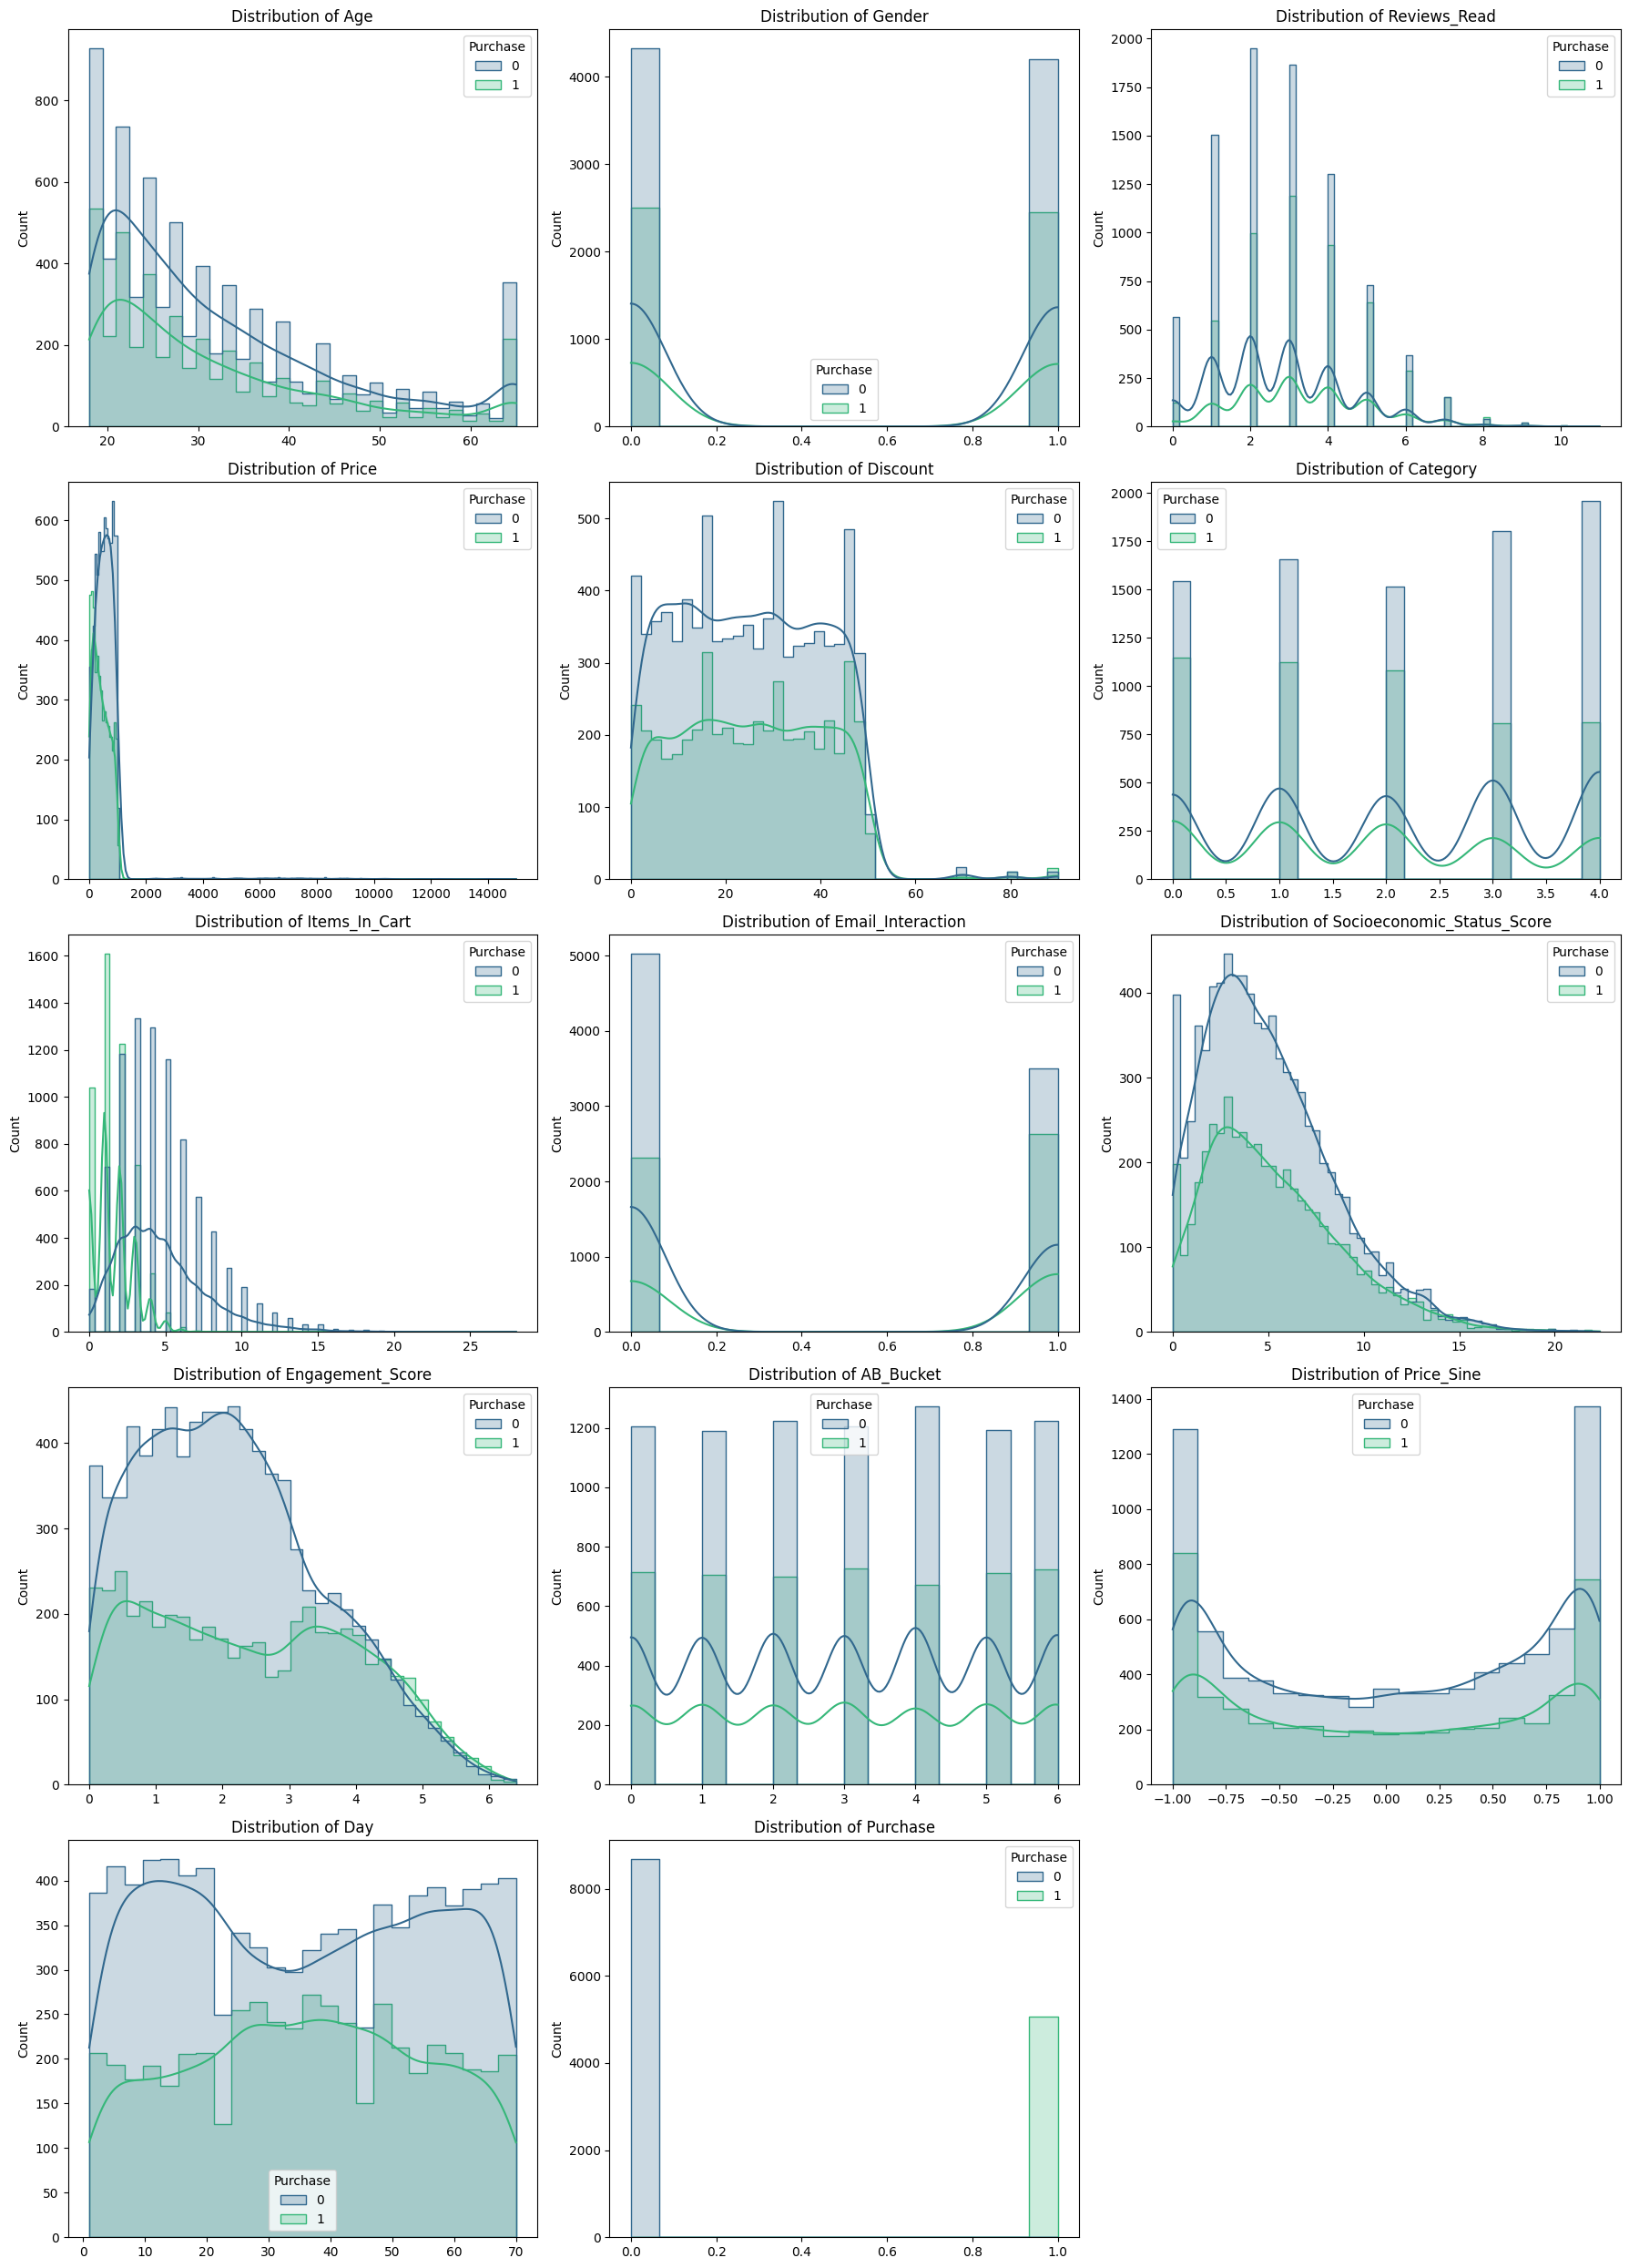

In [21]:
import math

# 1. Identify Numerical Columns (excluding IDs)
cols_to_ignore = ['id', 'Session_ID']
numerical_cols = df.select_dtypes(include=['float64', 'int64']).columns
numerical_cols = [c for c in numerical_cols if c not in cols_to_ignore]

# 2. Calculate Grid Size
num_plots = len(numerical_cols)
cols = 3  # Number of columns in the grid
rows = math.ceil(num_plots / cols)

# 3. Create Figure
fig, axes = plt.subplots(rows, cols, figsize=(18, 5 * rows))
axes = axes.flatten()  # Flattens the grid into a list for easy looping

# 4. Loop and Plot
for i, col in enumerate(numerical_cols):
    sns.histplot(
        data=df, 
        x=col, 
        hue='Purchase', 
        kde=True, 
        element="step", 
        ax=axes[i],  # Plot on the specific subplot
        palette='viridis'
    )
    axes[i].set_title(f"Distribution of {col}")
    axes[i].set_xlabel("") # Clean up x-label to save space

# 5. Hide empty subplots (if plots don't fill the grid perfectly)
for i in range(num_plots, len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()

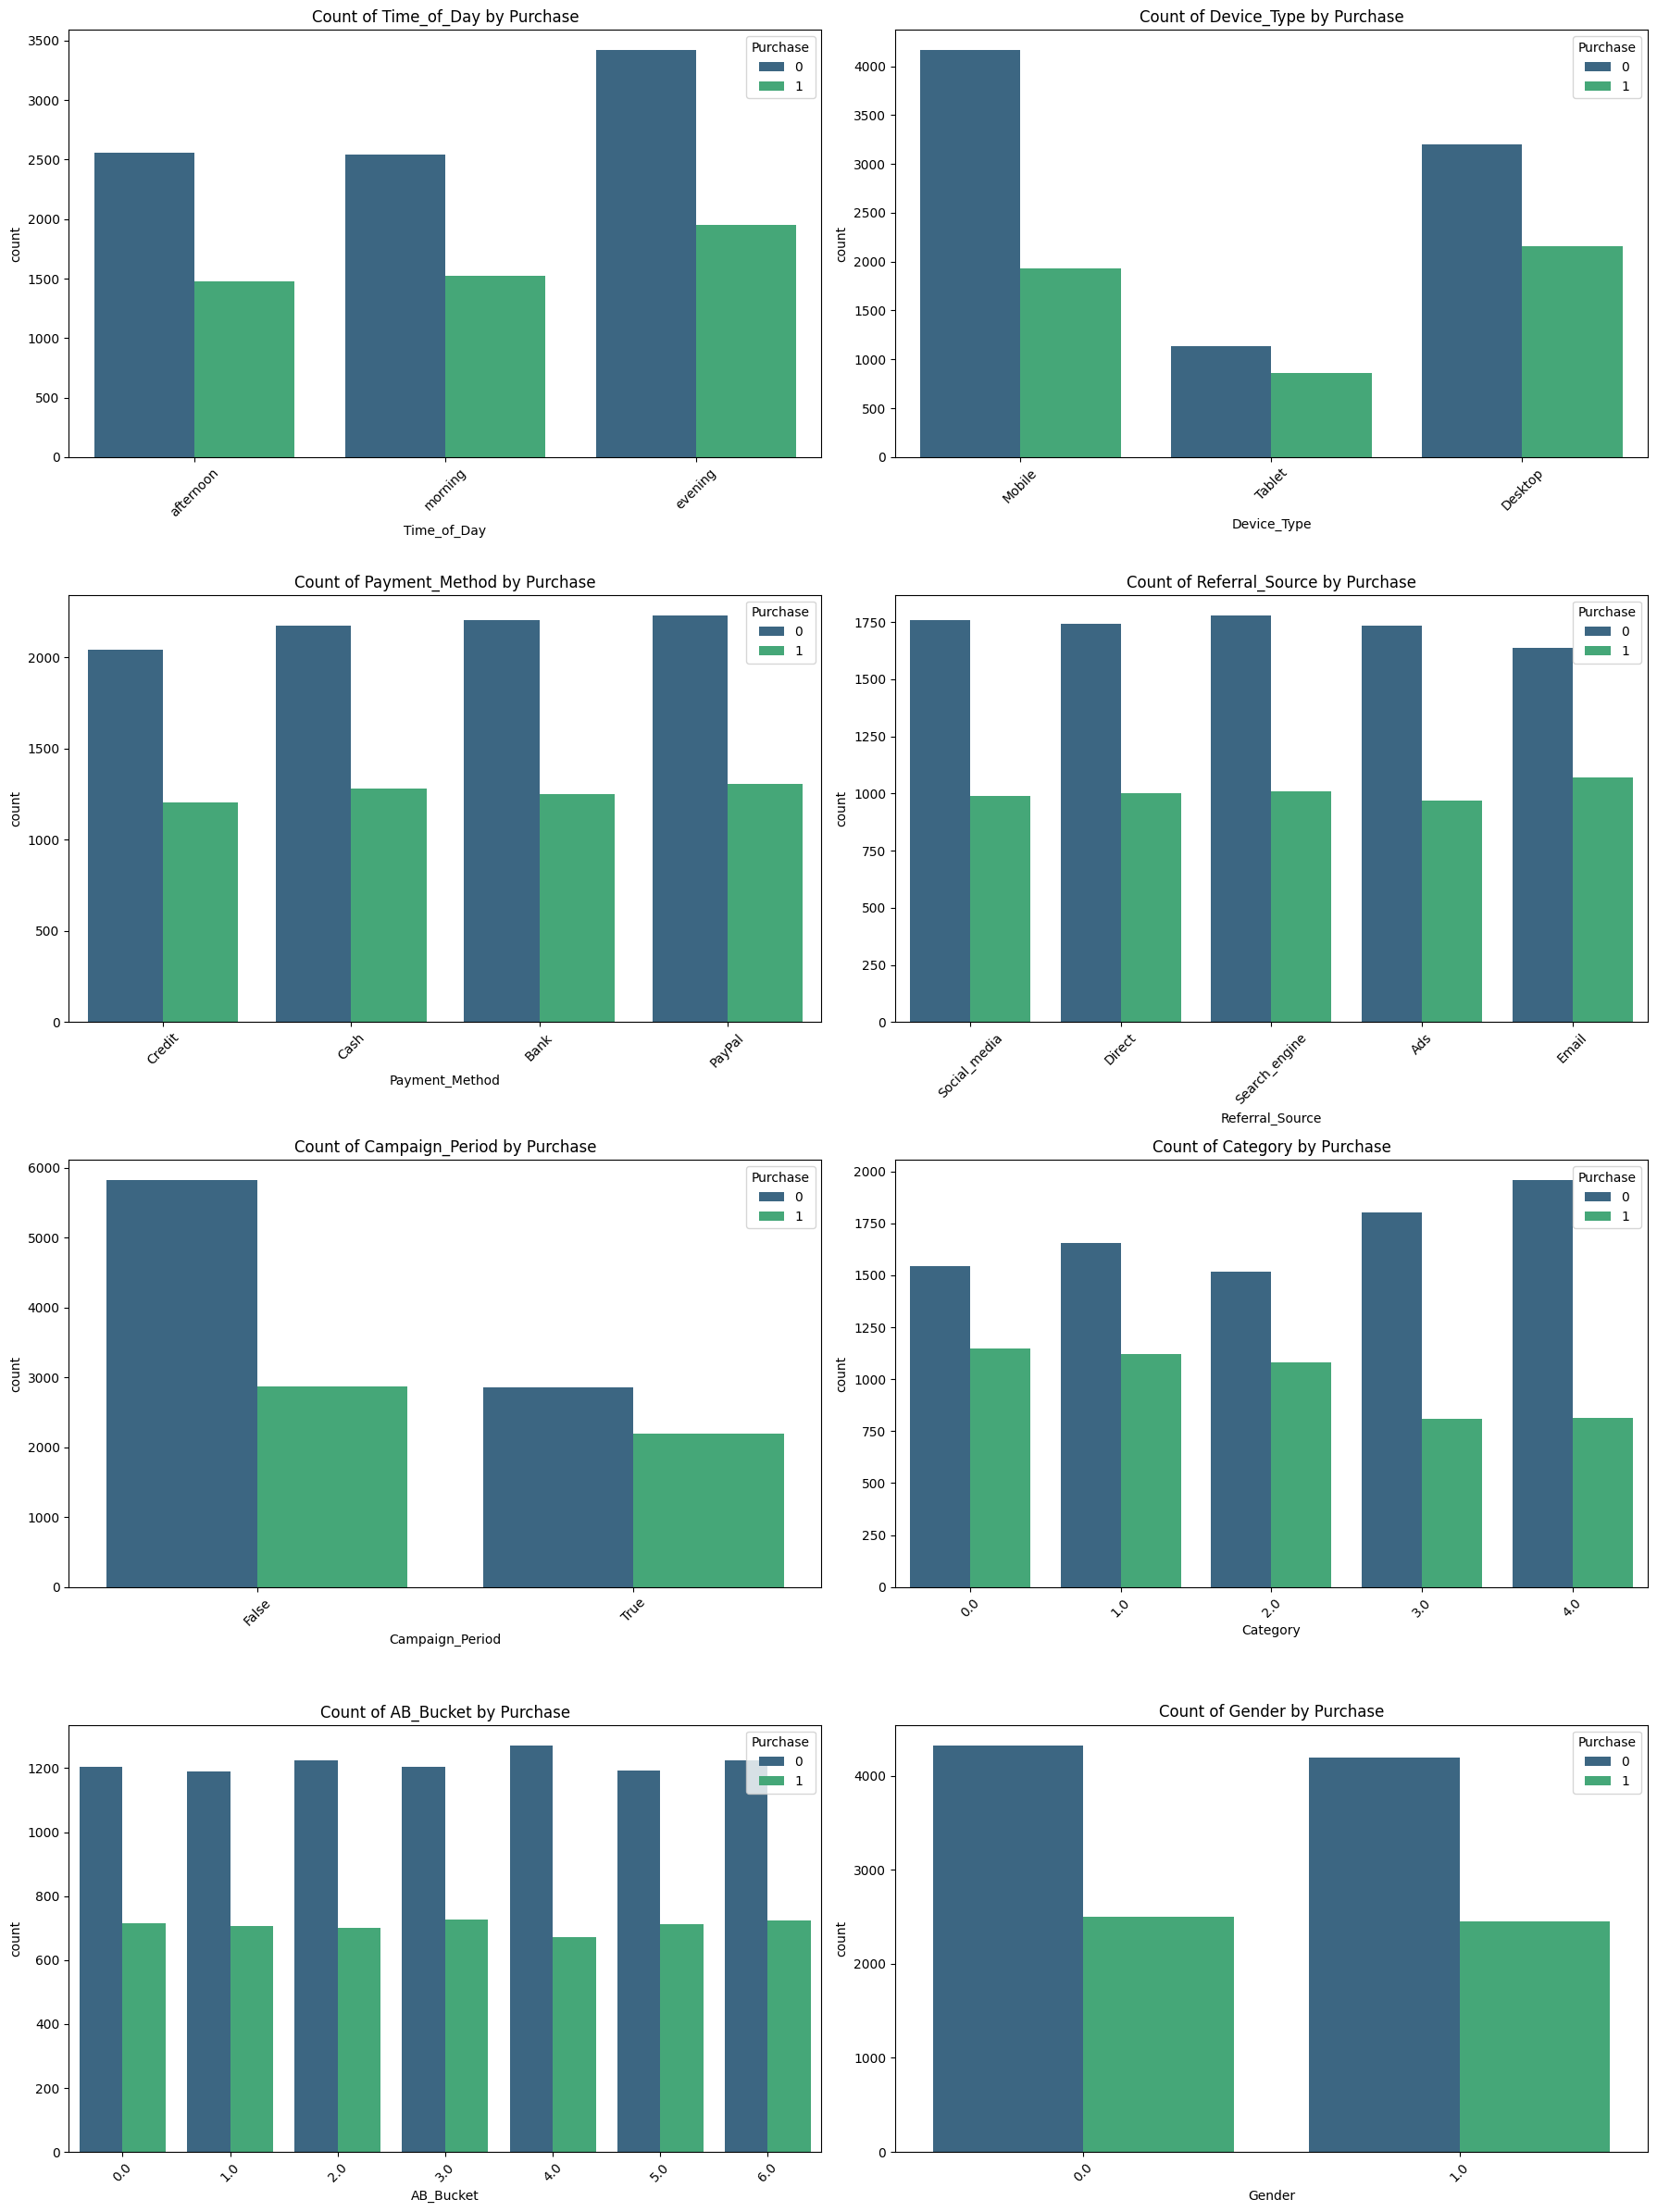

In [22]:
# 1. Identify Numerical Columns (excluding IDs)
target_cols = ['Time_of_Day', 'Device_Type', 'Payment_Method', 'Referral_Source', 'Campaign_Period', 'Category', 'AB_Bucket', 'Gender']
categorical_cols = [c for c in target_cols if c in df.columns]

num_plots = len(categorical_cols)
cols = 2  # Fewer columns because categorical labels need width
rows = math.ceil(num_plots / cols)

# 3. Create Figure
fig, axes = plt.subplots(rows, cols, figsize=(18, 6 * rows))
axes = axes.flatten()

# 4. Loop and Plot
for i, col in enumerate(categorical_cols):
    sns.countplot(
        data=df, 
        x=col, 
        hue='Purchase', 
        ax=axes[i], 
        palette='viridis'
    )
    axes[i].set_title(f"Count of {col} by Purchase")
    axes[i].tick_params(axis='x', rotation=45) # Rotate labels so they don't overlap

# 5. Hide empty subplots
for i in range(num_plots, len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()

C:\Users\ebist\AppData\Local\Temp\ipykernel_24084\2792975007.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
C:\Users\ebist\AppData\Local\Temp\ipykernel_24084\2792975007.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
C:\Users\ebist\AppData\Local\Temp\ipykernel_24084\2792975007.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
C:\Users\ebist\AppData\Local\Temp\ipykernel_24084\2792975007.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `h

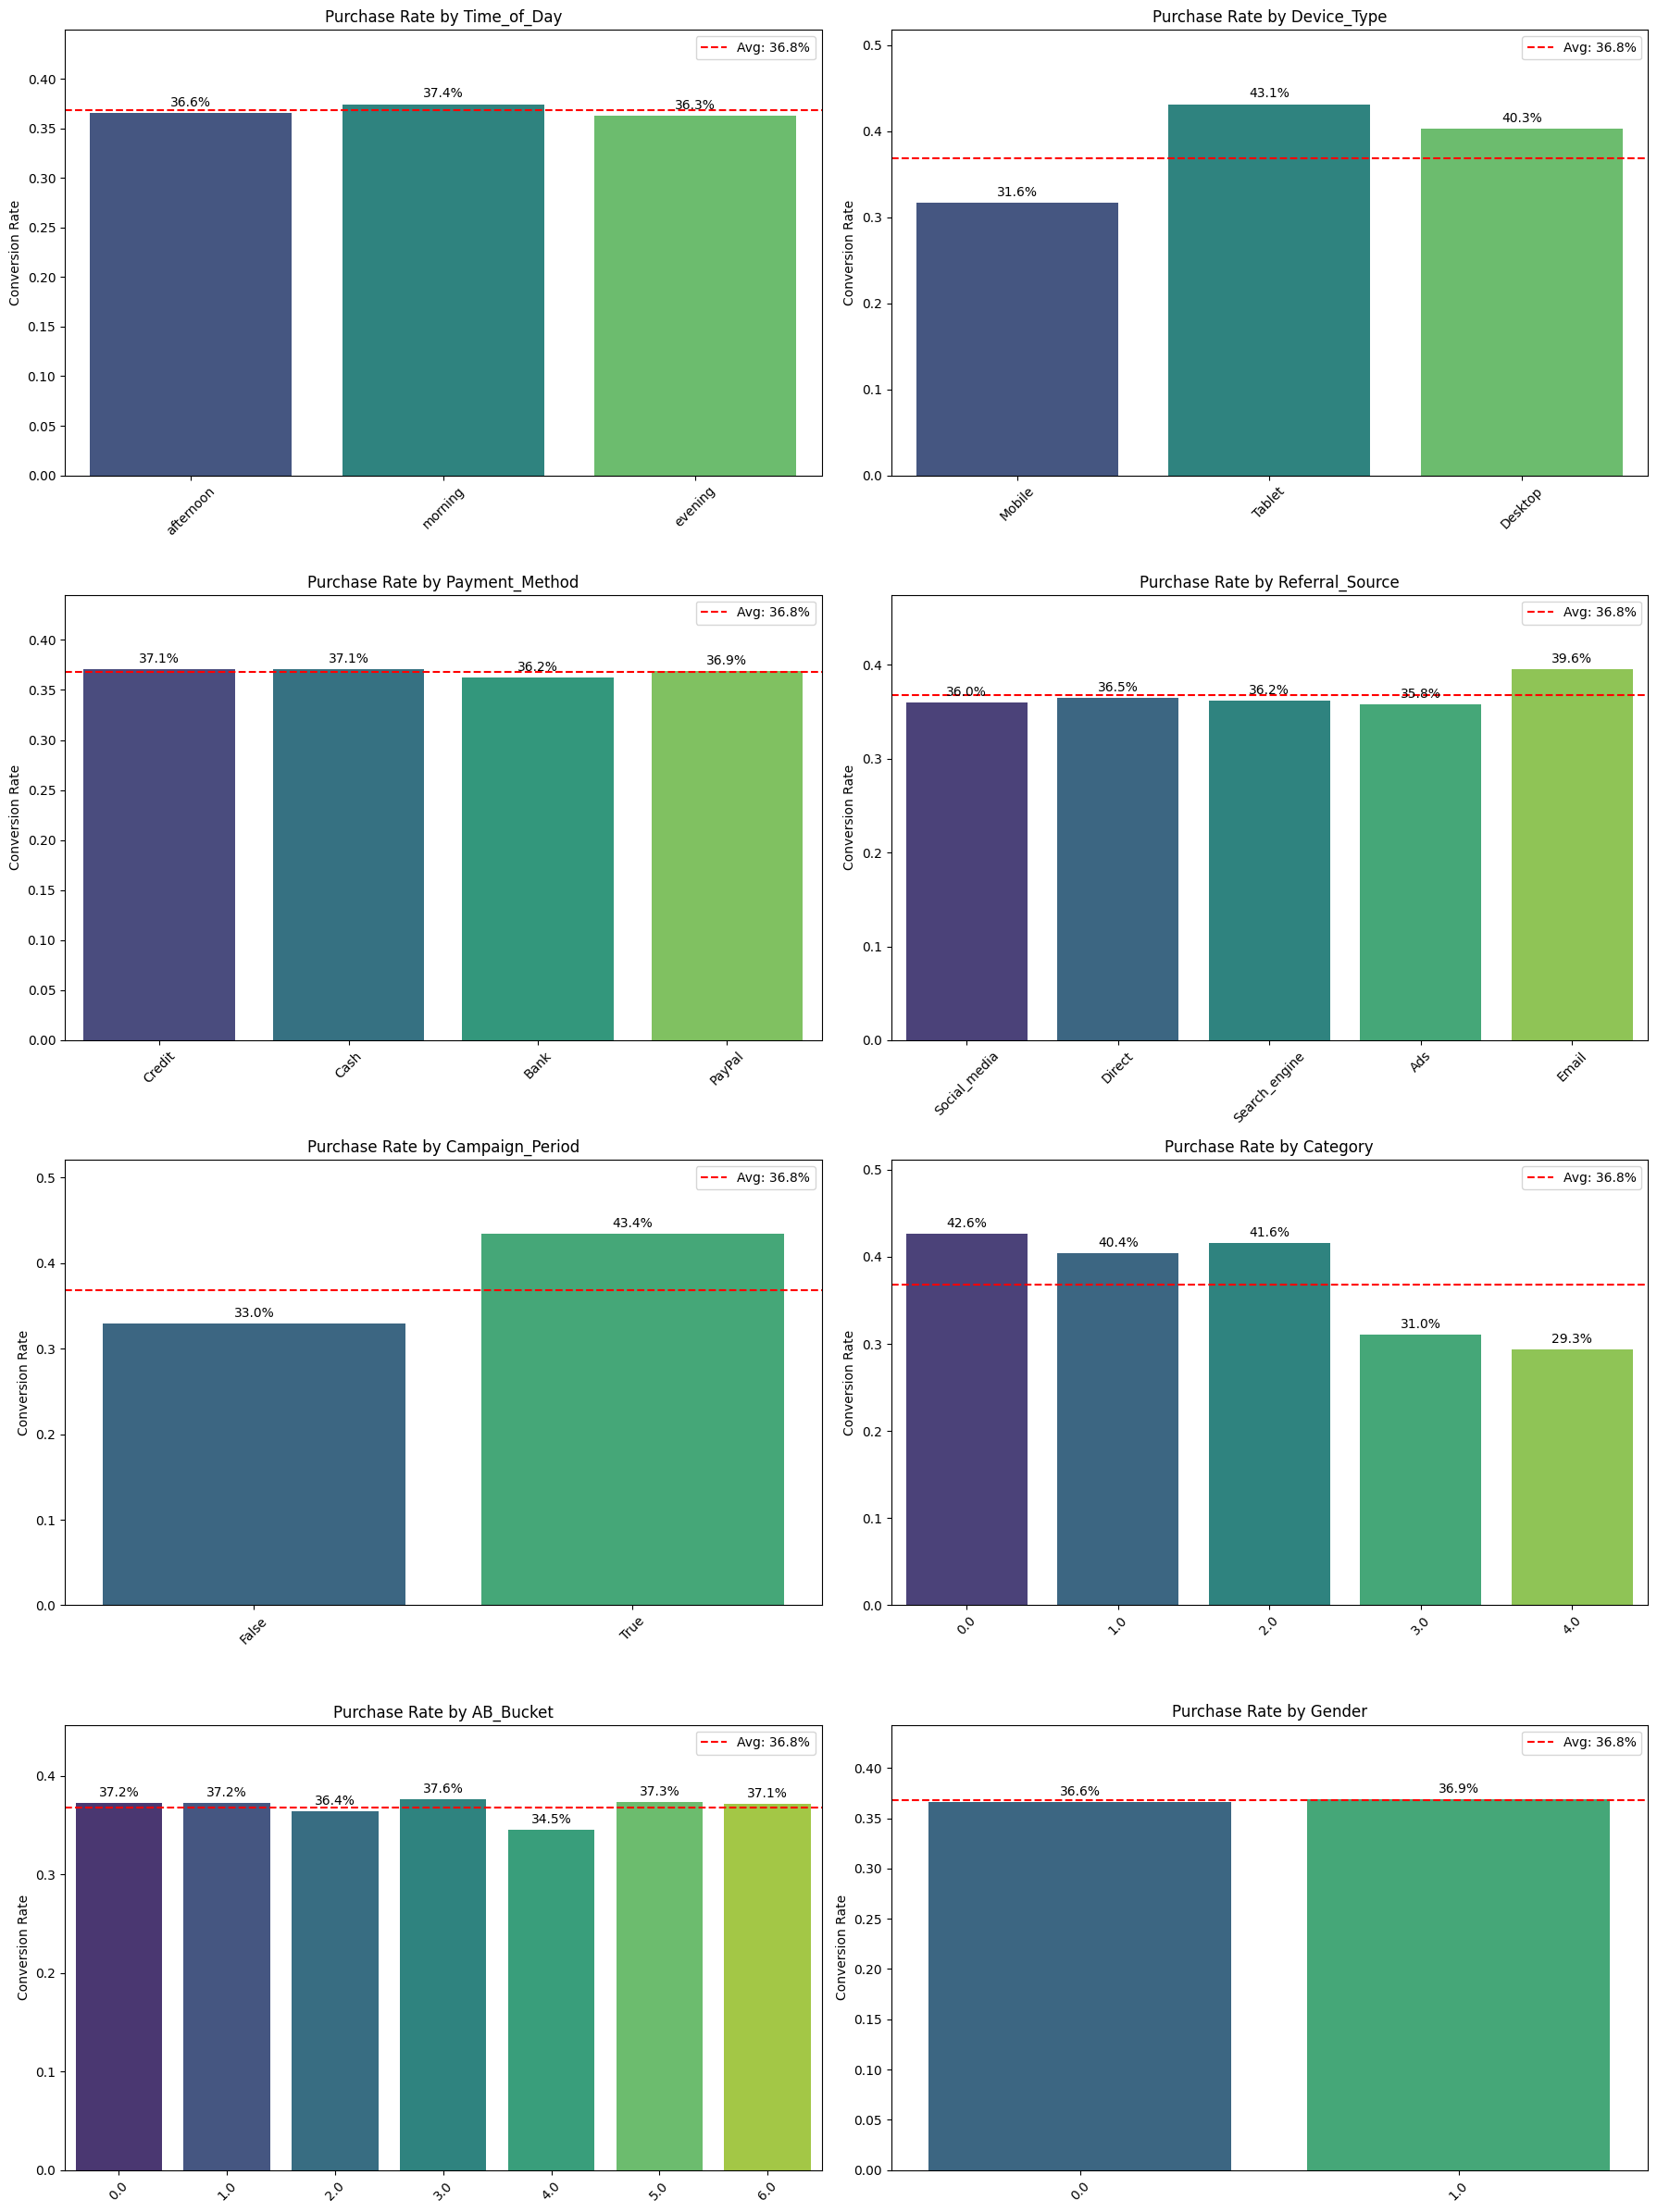

In [23]:
# 1. Define Columns
target_cols = ['Time_of_Day', 'Device_Type', 'Payment_Method', 'Referral_Source', 'Campaign_Period', 'Category', 'AB_Bucket', 'Gender']
categorical_cols = [c for c in target_cols if c in df.columns]

# 2. Calculate Grid
num_plots = len(categorical_cols)
cols = 2
rows = math.ceil(num_plots / cols)

# 3. Create Figure
fig, axes = plt.subplots(rows, cols, figsize=(18, 6 * rows))
axes = axes.flatten()

# Calculate Global Purchase Rate (Baseline)
global_rate = df['Purchase'].mean()

# 4. Loop and Plot
for i, col in enumerate(categorical_cols):
    # sns.barplot calculates the MEAN by default (which equals the Rate for 0/1 data)
    sns.barplot(
        data=df, 
        x=col, 
        y='Purchase', 
        ax=axes[i], 
        palette='viridis',
        errorbar=None # Remove the little vertical lines (confidence intervals) for cleaner look
    )
    
    # Add the Global Average Line (Red Dashed Line)
    axes[i].axhline(global_rate, color='red', linestyle='--', label=f'Avg: {global_rate:.01%}')
    
    # Titles and Labels
    axes[i].set_title(f"Purchase Rate by {col}")
    axes[i].set_ylabel("Conversion Rate")
    axes[i].set_xlabel("")
    axes[i].tick_params(axis='x', rotation=45)
    axes[i].legend(loc='upper right')

    # Add Percentage Labels on top of bars
    for container in axes[i].containers:
        # Calculate the label: val * 100 gives the percentage
        labels = [f'{val*100:.1f}%' for val in container.datavalues]
        
        # Pass the calculated labels instead of using 'fmt'
        axes[i].bar_label(container, labels=labels, padding=3)

    # Fix Y-axis to be 0-1 (or slightly higher for text)
    axes[i].set_ylim(0, df.groupby(col)['Purchase'].mean().max() * 1.2)

# 5. Hide empty subplots
for i in range(num_plots, len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()

C:\Users\ebist\AppData\Local\Temp\ipykernel_24084\482484490.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(
C:\Users\ebist\AppData\Local\Temp\ipykernel_24084\482484490.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(
C:\Users\ebist\AppData\Local\Temp\ipykernel_24084\482484490.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(
C:\Users\ebist\AppData\Local\Temp\ipykernel_24084\482484490.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable 

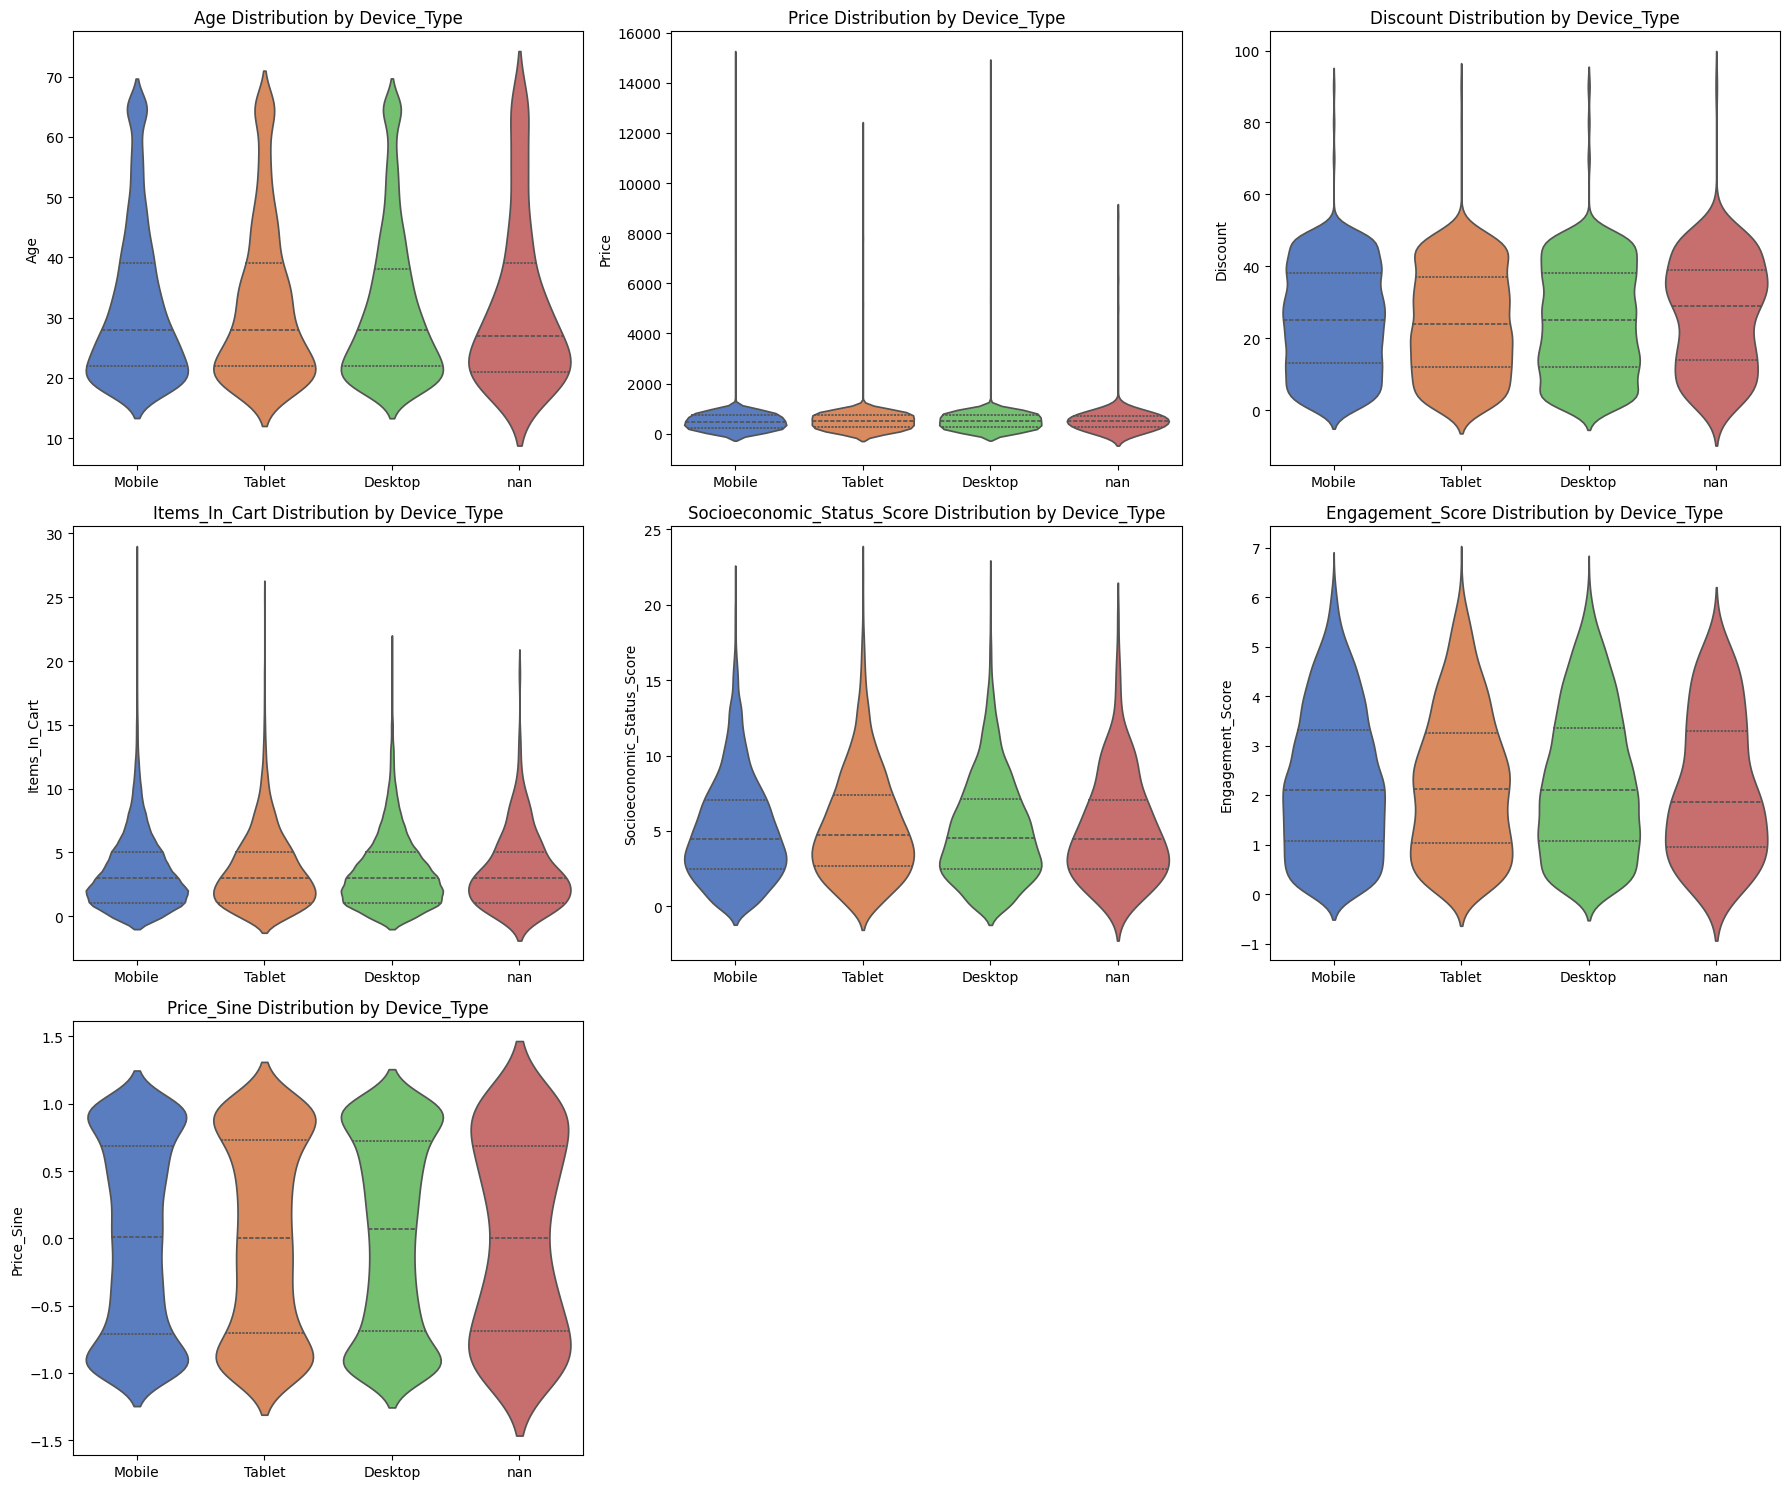

In [24]:

# 1. Define the Numerical variables you want to compare
features_to_plot = [
    'Age', 
    'Price', 
    'Discount', 
    'Items_In_Cart', 
    'Socioeconomic_Status_Score', 
    'Engagement_Score',
    'Price_Sine' # Optional if you kept it
]

# Filter to ensure columns exist
features_to_plot = [c for c in features_to_plot if c in df.columns]

# 2. Setup the Grid
cols = 3
rows = math.ceil(len(features_to_plot) / cols)
fig, axes = plt.subplots(rows, cols, figsize=(18, 5 * rows))
axes = axes.flatten()

# 3. Create a temporary view for plotting
# We create a copy so we don't mess up the original dataframe
plot_df = df.copy()
# Force Gender to be a string so Seaborn treats it as a category, not a number
plot_df['Device_Type'] = plot_df['Device_Type'].astype(str)

# 4. Loop and Plot
for i, col in enumerate(features_to_plot):
    sns.violinplot(
        data=plot_df, 
        x='Device_Type',      # The Category to split by
        y=col,           # The Numerical variable to measure
        ax=axes[i], 
        palette='muted',
        inner="quartile" # Draws dashed lines for median and quartiles
    )
    axes[i].set_title(f"{col} Distribution by Device_Type")
    axes[i].set_xlabel("")

# 5. Hide empty subplots
for i in range(len(features_to_plot), len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()